In [47]:
import pandas as pd
import numpy as np
from tqdm import tqdm_notebook
from scipy.spatial import distance
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.io import loadmat
from PIL import Image
import os
import warnings
from scipy.stats import wilcoxon
from scipy.stats import mannwhitneyu
warnings.filterwarnings('ignore')
plt.style.use('default')

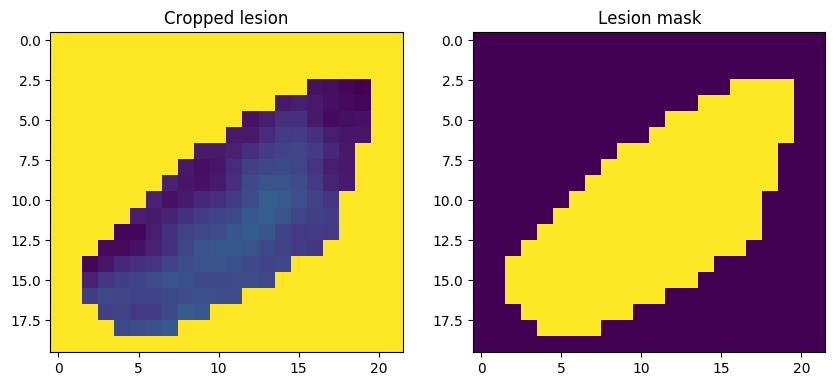

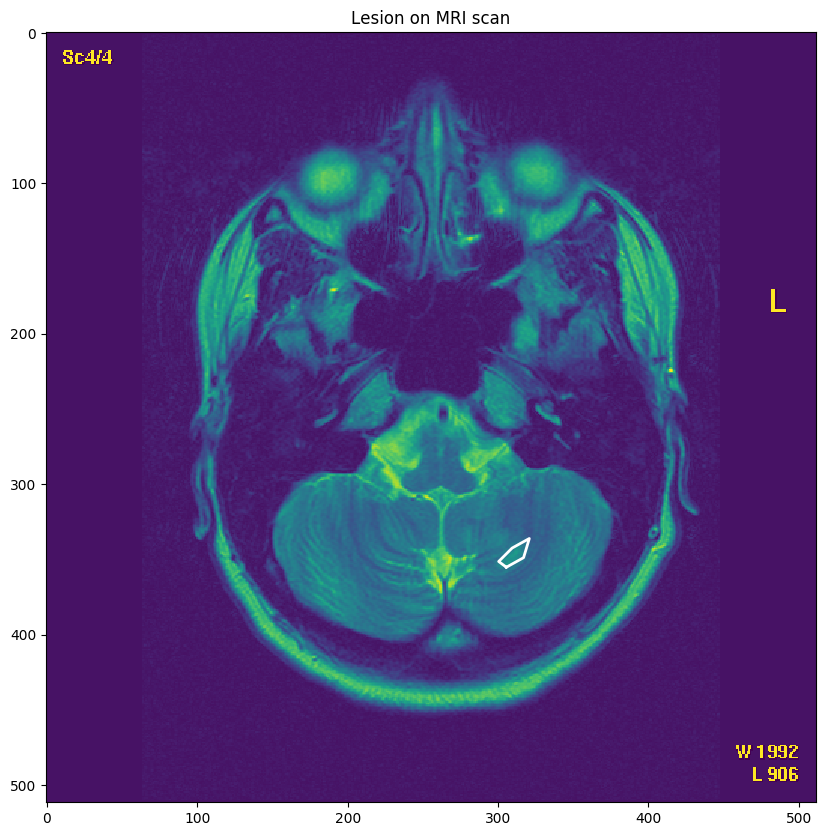

In [48]:
im = Image.open("../data/Initial & repeat MRI in MS-Free Dataset/TZN/2/IM_00004.TIF")
lesion_scan = np.array(im)

lesion_data = loadmat("../data/Initial & repeat MRI in MS-Free Dataset/TZN/2/IM_00004_1.plq")

plt.figure(figsize=(10, 5))
plt.subplot(121)
plt.imshow(lesion_data["reg"])
plt.title("Cropped lesion")
plt.subplot(122)
plt.imshow(lesion_data["mask"])
plt.title("Lesion mask")
plt.show()

plt.figure(figsize=(10, 10))
plt.imshow(lesion_scan)
plt.plot(lesion_data["xi"], lesion_data["yi"], color="white", linewidth=2)
plt.title("Lesion on MRI scan")
plt.show()

In [49]:
# Process plq
def process_plq(path):
    leison = loadmat(path)
    return leison["mask"].sum(), (leison["reg"] * leison["mask"]).mean() / 255

shapes = []
for root, _, files in os.walk('../data/Initial & repeat MRI in MS-Free Dataset/'):
    for f in files:
        if ".plq" in f:
            _,_,_, patient, stage = root.split('/')
            path = root + "/" + f
            size, intensity = process_plq(path)
            shapes.append((size, intensity, patient, stage))

In [50]:
shapes_df = pd.DataFrame(shapes, columns = ['size', 'intensity', 'patient', 'stage'])

In [51]:
patient_progress_df = shapes_df.groupby(['stage', 'patient']).agg({'size': ["count", "mean"], 'intensity': ["mean"]}).reset_index()

patient_progress_df.columns = ['stage', 'patient', 'number', 'size_mean', 'intensity_mean']
patient_progress_df.head()

,stage,patient,number,size_mean,intensity_mean
0,1,AA,38,185.026316,0.308227
1,1,ARK,7,38.142857,0.218597
2,1,AT,9,95.111111,0.289054
3,1,CHEM,7,53.428571,0.197603
4,1,CHP,19,30.368421,0.157853


In [52]:
patient_progress_df = patient_progress_df[patient_progress_df.stage == "1"][["patient", "number", "intensity_mean", "size_mean"]].merge(
    patient_progress_df[patient_progress_df.stage == "2"][["patient", "number", "intensity_mean", "size_mean"]],
    how="left",
    on="patient",
    suffixes=("_initial", "_repeated")
)

In [53]:
patient_progress_df["size_change"] = patient_progress_df["size_mean_repeated"] / patient_progress_df["size_mean_initial"]
patient_progress_df["intensity_change"] = patient_progress_df["intensity_mean_repeated"] / patient_progress_df["intensity_mean_initial"]
patient_progress_df["number_change"] = patient_progress_df["number_repeated"] / patient_progress_df["number_initial"]

In [54]:
patient_progress_df.head()

,patient,number_initial,intensity_mean_initial,size_mean_initial,number_repeated,intensity_mean_repeated,size_mean_repeated,size_change,intensity_change,number_change
0,AA,38,0.308227,185.026316,36,0.308126,186.000000,1.005262,0.999671,0.947368
1,ARK,7,0.218597,38.142857,10,0.190021,33.000000,0.865169,0.869278,1.428571
2,AT,9,0.289054,95.111111,8,0.197010,80.625000,0.847693,0.681566,0.888889
3,CHEM,7,0.197603,53.428571,9,0.150787,45.000000,0.842246,0.763078,1.285714
4,CHP,19,0.157853,30.368421,22,0.212683,29.181818,0.960926,1.347349,1.157895


#### EDSS Matching


In [55]:
edss_score = pd.read_csv('../data/Initial & repeat MRI in MS-Free Dataset/EDSS_matching.csv')
patients_df = pd.read_excel("../data/Initial & repeat MRI in MS-Free Dataset/PatientCodes-Names.xls")
patients_df.drop(0, inplace=True)
patients_df.drop(columns=["Unnamed: 7", "Unnamed: 6"], inplace=True)
edss_score.drop(columns='Unnamed: 0', inplace=True)

#### Shape Features -- Try them out [Use these features to try on 1 & 2 folders seperately -- Perform wilcoxon test on top of them]
#### 1. Maximum length x and y coords
#### 2. Area -- https://en.wikipedia.org/wiki/Shoelace_formula
#### 3. Perimeter -- 
#### 4. perimeter2/area, 

In [79]:
def define_parameter(coords: list)->float:
    """
    Calculating the parameter for a specific polygon
    Args:
        coords: (x, y) coordinates of a polygon
    
    Returns:
        The parameter of the polygon with calculation of euclidean distance between 2 coords
    """
    if type(coords) != list or len(coords) == 0 or coords is None:
        raise ValueError("Please check the coordinates again!!!")
    
    i=0; per = 0
    while i < len(coords)-1:
        coords0, coords1 = coords[i], coords[i+1]
        per+=distance.euclidean(coords0, coords1)
        i+=1;
    return per

def define_area(x: list, y: list)->float:
    """
    Calculating the Area of a polygon using shoelace formula : https://en.wikipedia.org/wiki/Shoelace_formula
    Args:
        x: list of x values for all the coordinates
        y: list of y values for all the coordinates
        
    Returns:
        Area of a polygon with float format
    """
    if x is None or y is None or len(x) == 0 or len(y) == 0 or type(x) != np.ndarray or type(y) != np.ndarray or type(x) != type(y):
        raise ValueError("Please check the x and y coords!!!")
    elif len(x) != len(y):
        raise ValueError("x and y coordinates are not of same length!!!")
    return 0.5*np.abs(np.dot(x,np.roll(y,1))-np.dot(y,np.roll(x,1)))

def process_plq_coordinates(path: str)->list:
    """
    This function is responsible for calculation of multiple shape features together i.e. Max length of x & y coords, 
    area, perimeter, perimeter**2/area
    Args:
        path: string value of a single .plq file
    Returns:
        a list of all the values in together
    """
    if path in ("", " ") or type(path) != str:
        raise ValueError("Please recheck the file path!!!")
    elif not os.path.exists(path):
        raise ValueError("File path doesn't exists!!!")
        
    params = loadmat(path)
    x, y = params["xi"].reshape(-1), params["yi"].reshape(-1)
    ar = define_area(x, y)
    per = define_parameter(list(zip(x, y)))
    return list([params["xi"][np.argmax(params["xi"].reshape(-1))] - params["xi"][np.argmin(params["xi"].reshape(-1))], 
                params["xi"][np.argmax(params["yi"].reshape(-1))] - params["yi"][np.argmin(params["yi"].reshape(-1))], 
                per, ar, (per**2)/ar])
    
def read_points(path:str)->list:
    """
    An intermediate function which calculates the average value of each shape feature for a patient as well as returns
    whole list of values to calculate the mannwhitney test
    
    Args:
        path: string value of a set of .plq files
    Returns:
        a list of individual values for Max length of x & y coords, area, perimeter, perimeter**2/area as well as their
        mean values.
    """
    x_points = []; y_points = []; area = []; per = []; per_by_area = [];
    for root, _, files in os.walk(path):
        for index, file in enumerate(sorted([f for f in files if ".plq" in f])):
            z_index = int(file.split("_")[1].split(".")[0])
            path = root + "/" + file
            vals = process_plq_coordinates(path)
            x_points.append(vals[0][0]); 
            y_points.append(vals[1][0]);
            per.append(vals[2]); 
            area.append(vals[3]); 
            per_by_area.append(vals[4])
    return [x_points, y_points, area, per, per_by_area, np.mean(x_points), np.mean(y_points), np.mean(area), np.mean(per), np.mean(per_by_area)]
   
def calculate_MannWhitney(x: list, y: list)->list:
    """
    Calculates the Mannwhitney statistical test for a list of x and y values
    Args:
        x: list of x values i.e. 0 Months
        y: list of y values i.e. 6-12 Months
    Returns:
        statistics as well as p-value which defines the significance of a feature for a patient
    """
    return mannwhitneyu(x, y)

In [80]:
patients_df.loc[patients_df.CODE == "CHE", "CODE"] = "CHEM"
patients_to_lesions_df = patients_df[["CODE"]].copy().set_index("CODE")

for patient in tqdm_notebook(patients_to_lesions_df.index):
    x_points = []; y_points = []; area = []; per = []; per_by_area = [];
    for period in ["1", "2"]:
        path = "../data/Initial & repeat MRI in MS-Free Dataset/{}/{}".format(patient, period)
        points = read_points(path)
        x_points.append(points[0])
        y_points.append(points[1])
        per.append(points[3]); area.append(points[2]); per_by_area.append(points[4])
        patients_to_lesions_df.loc[patient, "lesions_{}_xcoords".format(period)] = points[5]
        patients_to_lesions_df.loc[patient, "lesions_{}_ycoords".format(period)] = points[6]
        patients_to_lesions_df.loc[patient, "lesions_{}_area".format(period)] = points[7]
        patients_to_lesions_df.loc[patient, "lesions_{}_per".format(period)] = points[8]
        patients_to_lesions_df.loc[patient, "lesions_{}_per_by_area".format(period)] = points[9]
    patients_to_lesions_df.loc[patient, "lesion_xcoords_mannwhitney"] = calculate_MannWhitney(x_points[0], x_points[1])[1]
    patients_to_lesions_df.loc[patient, "lesion_ycoords_mannwhitney"] = calculate_MannWhitney(y_points[0], y_points[1])[1]
    patients_to_lesions_df.loc[patient, "lesion_area_mannwhitney"] = calculate_MannWhitney(area[0], area[1])[1]
    patients_to_lesions_df.loc[patient, "lesion_per_mannwhitney"] = calculate_MannWhitney(per[0], per[1])[1]
    patients_to_lesions_df.loc[patient, "lesion_per_by_area_mannwhitney"] = calculate_MannWhitney(per_by_area[0], x_points[1])[1]

A Jupyter Widget

In [66]:
# At this point we have 2 different cols for each feature type. Implement the Mann Whitney U Test
wilcoxon(patients_to_lesions_df.lesions_1_xcoords, patients_to_lesions_df.lesions_2_xcoords)

WilcoxonResult(statistic=277.0, pvalue=0.1751110121160112)

In [65]:
wilcoxon(patients_to_lesions_df.lesions_1_ycoords, patients_to_lesions_df.lesions_2_ycoords)

WilcoxonResult(statistic=358.0, pvalue=0.8561490233719683)

In [64]:
wilcoxon(patients_to_lesions_df.lesions_1_area, patients_to_lesions_df.lesions_2_area)

WilcoxonResult(statistic=273.0, pvalue=0.15737015953167466)

In [63]:
wilcoxon(patients_to_lesions_df.lesions_1_per, patients_to_lesions_df.lesions_2_per)

WilcoxonResult(statistic=290.0, pvalue=0.24303547341118348)

In [62]:
wilcoxon(patients_to_lesions_df.lesions_1_per_by_area, patients_to_lesions_df.lesions_2_per_by_area)

WilcoxonResult(statistic=357.0, pvalue=0.8447817999706625)

In [84]:
edss_score.loc[edss_score.CODE == "CHE", "CODE"] = "CHEM"
edss_score.index = edss_score.CODE
edss_score.drop(columns=['CODE'], inplace=True)
edss_score.head()

,EDSS2,EDSS5
CODE,,
AT,1.0,(2.0)
AA,2.0,(2.0)
GPE,3.0,(3.0)
HC,1.5,(2.5)
IO,3.0,(2.5)


In [87]:
patients_to_lesions_df = pd.merge(patients_to_lesions_df, edss_score, left_index=True, right_index=True)
patients_to_lesions_df.head()

,lesions_1_xcoords,lesions_1_ycoords,lesions_1_area,lesions_1_per,lesions_1_per_by_area,lesions_2_xcoords,lesions_2_ycoords,lesions_2_area,lesions_2_per,lesions_2_per_by_area,lesion_xcoords_mannwhitney,lesion_ycoords_mannwhitney,lesion_area_mannwhitney,lesion_per_mannwhitney,lesion_per_by_area_mannwhitney,EDSS2,EDSS5
CODE,,,,,,,,,,,,,,,,,
AT,13.331538,-7.728844,98.386840,41.102055,18.925791,14.092929,-18.553535,91.339839,44.071824,25.465494,0.480813,0.206703,0.442617,0.404947,0.081468,1.0,(2.0)
AA,15.800957,-13.000744,185.741466,53.140829,16.421193,15.572615,0.014366,188.433924,54.655535,17.411255,0.420682,0.174764,0.497843,0.296206,0.138505,2.0,(2.0)
GPE,12.955023,-15.011947,131.225355,45.194149,17.902966,17.452354,24.995172,202.322605,56.323052,18.419062,0.000644,0.006310,0.001047,0.001923,0.031652,3.0,(3.0)
HC,28.341010,-22.585628,668.616790,96.999808,18.350229,18.115786,-33.047273,243.776688,61.914857,17.538156,0.009543,0.357877,0.004254,0.007518,0.416272,1.5,(2.5)
IO,19.779699,-36.748866,269.457238,64.087474,19.445774,15.515152,-40.423932,162.578535,54.036748,19.376829,0.006197,0.396618,0.029606,0.031598,0.000003,3.0,(2.5)


In [96]:
def calculate_change(row, col):
    return row['lesions_2_{}'.format(col)] / row['lesions_1_{}'.format(col)]

def fix_edss5(x):
    x = x.replace(')','').replace('(', '')
    return x

patients_to_lesions_df['EDSS5'] = patients_to_lesions_df['EDSS5'].apply(lambda x: fix_edss5(x)).astype('float32')
patients_to_lesions_df['xcoords_change'] = patients_to_lesions_df.apply(lambda x: calculate_change(x, 'xcoords'), axis=1)
patients_to_lesions_df['ycoords_change'] = patients_to_lesions_df.apply(lambda x: calculate_change(x, 'ycoords'), axis=1)
patients_to_lesions_df['area_change'] = patients_to_lesions_df.apply(lambda x: calculate_change(x, 'area'), axis=1)
patients_to_lesions_df['per_change'] = patients_to_lesions_df.apply(lambda x: calculate_change(x, 'per'), axis=1)
patients_to_lesions_df['per_by_area_change'] = patients_to_lesions_df.apply(lambda x: calculate_change(x, 'per_by_area'), axis=1)

In [97]:
patients_to_lesions_df.corr()['EDSS2']

lesions_1_xcoords                -0.183468
lesions_1_ycoords                -0.456500
lesions_1_area                   -0.227646
lesions_1_per                    -0.186967
lesions_1_per_by_area             0.166527
lesions_2_xcoords                -0.059621
lesions_2_ycoords                 0.100994
lesions_2_area                   -0.040572
lesions_2_per                    -0.040195
lesions_2_per_by_area             0.024101
lesion_xcoords_mannwhitney       -0.051400
lesion_ycoords_mannwhitney       -0.135111
lesion_area_mannwhitney          -0.064753
lesion_per_mannwhitney           -0.090234
lesion_per_by_area_mannwhitney    0.055716
EDSS2                             1.000000
EDSS5                             0.796705
xcoords_change                    0.206671
ycoords_change                    0.014357
area_change                       0.313708
per_change                        0.236329
per_by_area_change               -0.136504
Name: EDSS2, dtype: float64

In [98]:
patients_to_lesions_df.corr()['EDSS5']

lesions_1_xcoords                -0.088066
lesions_1_ycoords                -0.520052
lesions_1_area                   -0.169053
lesions_1_per                    -0.119064
lesions_1_per_by_area             0.154241
lesions_2_xcoords                 0.088015
lesions_2_ycoords                 0.024445
lesions_2_area                    0.098207
lesions_2_per                     0.094656
lesions_2_per_by_area             0.098130
lesion_xcoords_mannwhitney       -0.103341
lesion_ycoords_mannwhitney       -0.103429
lesion_area_mannwhitney          -0.150707
lesion_per_mannwhitney           -0.198725
lesion_per_by_area_mannwhitney    0.363267
EDSS2                             0.796705
EDSS5                             1.000000
xcoords_change                    0.288840
ycoords_change                   -0.013489
area_change                       0.467805
per_change                        0.358173
per_by_area_change               -0.040453
Name: EDSS5, dtype: float64

In [99]:
patients_to_lesions_df

,lesions_1_xcoords,lesions_1_ycoords,lesions_1_area,lesions_1_per,lesions_1_per_by_area,lesions_2_xcoords,lesions_2_ycoords,lesions_2_area,lesions_2_per,lesions_2_per_by_area,...,lesion_area_mannwhitney,lesion_per_mannwhitney,lesion_per_by_area_mannwhitney,EDSS2,EDSS5,xcoords_change,ycoords_change,area_change,per_change,per_by_area_change
CODE,,,,,,,,,,,,,,,,,,,,,
AT,13.331538,-7.728844,98.386840,41.102055,18.925791,14.092929,-18.553535,91.339839,44.071824,25.465494,...,0.442617,0.404947,8.146825e-02,1.0,2.0,1.057112,2.400558,0.928375,1.072254,1.345544
AA,15.800957,-13.000744,185.741466,53.140829,16.421193,15.572615,0.014366,188.433924,54.655535,17.411255,...,0.497843,0.296206,1.385050e-01,2.0,2.0,0.985549,-0.001105,1.014496,1.028504,1.060292
GPE,12.955023,-15.011947,131.225355,45.194149,17.902966,17.452354,24.995172,202.322605,56.323052,18.419062,...,0.001047,0.001923,3.165153e-02,3.0,3.0,1.347150,-1.665019,1.541795,1.246247,1.028827
HC,28.341010,-22.585628,668.616790,96.999808,18.350229,18.115786,-33.047273,243.776688,61.914857,17.538156,...,0.004254,0.007518,4.162724e-01,1.5,2.5,0.639208,1.463199,0.364599,0.638299,0.955746
IO,19.779699,-36.748866,269.457238,64.087474,19.445774,15.515152,-40.423932,162.578535,54.036748,19.376829,...,0.029606,0.031598,3.274096e-06,3.0,2.5,0.784398,1.100005,0.603356,0.843172,0.996455
MJ,25.577514,-12.653843,401.417921,86.523635,22.692975,23.621027,0.820614,361.442880,78.206934,20.040879,...,0.442269,0.387165,2.095334e-01,1.5,1.5,0.923508,-0.064851,0.900415,0.903879,0.883131
IPH,15.738451,-31.613362,200.478885,58.216320,18.456959,15.822426,-41.588978,211.501848,59.093876,18.344969,...,0.326313,0.354870,2.782526e-02,2.5,3.0,1.005336,1.315551,1.054983,1.015074,0.993932
KM,20.972471,81.201106,396.760552,70.636963,16.559004,22.415920,69.795025,324.427613,68.703096,15.258794,...,0.446965,0.500000,3.097408e-02,1.0,1.0,1.068826,0.859533,0.817691,0.972622,0.921480
NP,16.238806,-22.129353,155.319720,48.936997,17.124124,14.241520,-42.608774,122.987559,46.683538,18.548020,...,0.324861,0.267862,4.518257e-02,2.5,5.0,0.877005,1.925441,0.791835,0.953952,1.083151


From initial investigation, it seems that the raw area, per, per^2/area has almost no impact over the target. The ycoords impact though has increased over the time. From correlation table, we can see that area, perimiter and xcoords has an impact over the target i.e. EDSS score correlation has increased over time. 